# Real Options Valuation of Bitcoin Mining Operations: A Hedged Monte Carlo Approach

## 1. Introduction and Motivation
Bitcoin mining is a highly capital-intensive industry characterized by extreme margin volatility. Profitability is dictated by two primary stochastic drivers: the revenue generated per unit of computational power (**Hashprice**, driven by Bitcoin's market price and network difficulty) and the operational cost of electricity. 

Traditionally, capital budgeting for mining facilities relies on static **Discounted Cash Flow (DCF)** and **Net Present Value (NPV)** analyses. However, these deterministic models consistently fail to accurately price mining assets because they assume a rigid operating strategy and ignore the immense value of **managerial flexibility** in the face of volatility.

## 2. Objective
The objective of this notebook is to value a mid-scale Bitcoin mining facility using **Real Options Analysis (ROA)**. We seek to quantify the premium generated by operational flexibility—specifically:
1. **The Option to Suspend:** The ability to temporarily turn off machines when Hashprice drops below the marginal cost of power ("Crypto Winters").
2. **The Spark Spread Option:** The ability to dynamically curtail operations during acute, short-term wholesale electricity price spikes.

## 3. Methodology: Hedged Monte Carlo (HMC)
Due to the path-dependent nature of the switching options and the multi-factor stochastic environment (Bitcoin + Energy), standard analytical pricing formulas (e.g., Black-Scholes or Margrabe) are insufficient. 

Instead, this project implements a **Least-Squares Hedged Monte Carlo (HMC)** engine. By calculating the covariance between the project's cash flows and tradable hedging instruments (Bitcoin futures and Energy proxies), the algorithm computes the optimal early-exercise (suspension) boundary across thousands of simulated market paths.

## 4. Notebook Structure
To isolate the sources of strategic value, the analysis is conducted across three progressive scenarios:

* **Phase I: The Deterministic Baseline (Static NPV)** *Establishes the traditional value of the project assuming current market prices remain constant, optimizing only for the hardware's terminal salvage value.*
* **Phase II: The "Hosting" Case (Stochastic Revenue)** *Evaluates the Option to Suspend by exposing the project to Bitcoin/Hashprice volatility while fixing the energy cost via a third-party hosting agreement.*
* **Phase III: The "Grid" Case (Dual Stochasticity)** *Evaluates the Spark Spread Option by exposing the facility directly to the deregulated wholesale electricity grid (ERCOT), capturing both revenue and cost volatility.*

---
*Note: This notebook acts as the computational engine for the accompanying academic manuscript. All key tables, variables, and figures generated herein are automatically exported to the `article/` directory for LaTeX compilation.*

## 1. Setup, Data, and Global Parameters

### 1.2 Import the libraries

In [1]:
import os
import sys
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import custom modules
import src.read_data as rd
import src.simulations as sm
import src.g_functions as gf
import src.options as op
import src.visualization as vs
from src.export import export_figure, export_latex_table, export_params

# Plot styling
vs.set_professional_style()

### 1.3 Parameters

In [2]:
valuation_date = dt.datetime(2023, 1, 1)
data_path = 'C:/Users/fe_ma/Data'
optionality_window = 3 # In months
starting_valuation_window = 0 # In months
project_duration = 5 # years
rho = 0.05

days_in_month = (365*4 + 1) / 48

optionality_window *= days_in_month # converting to days
optionality_window = int(optionality_window)

starting_valuation_window *= days_in_month
starting_valuation_window = int(starting_valuation_window)

project_duration *= 12 * days_in_month
project_duration = int(project_duration)

other_parameters = {}
other_parameters['valuation_date'] = valuation_date
other_parameters['optionality_window'] = optionality_window
other_parameters['starting_valuation_window'] = starting_valuation_window
other_parameters['project_duration'] = project_duration

other_parameters['rho'] = rho

# 1. Define Projection Horizon
projection_horizon = optionality_window + project_duration + starting_valuation_window
other_parameters['projection_horizon'] = projection_horizon

<!-- ## 2. Valuation Scenarios -->
## 2. The Strategic Baseline: Hybrid Hosting Model

To isolate the value of flexibility, we analyze the project under three distinct risk profiles. In all cases, the **Initial Investment (Capex)** is identical (we purchase the hardware), but the **Operational Risk** varies.

**1. The Deterministic Baseline (Static)**
* **Assumptions:** Bitcoin Price, Hashprice, and Electricity Cost remain constant at their $t=0$ values forever.
* **Goal:** Establishes the traditional NPV floor. It ignores all volatility.

**2. The "Hosting" Scenario (Fixed Cost, Stochastic Revenue)**
* **Assumptions:** Bitcoin/Hashprice follow a stochastic process (GBM). Electricity is **fixed** at the Hosting Rate ($0.065/kWh).
* **Flexibility:** We can pause mining if Hashprice drops too low, but we cannot benefit from cheap off-peak power.
* **Goal:** Quantifies the value of Bitcoin's upside volatility.

**3. The "Grid" Scenario (Stochastic Cost, Stochastic Revenue)**
* **Assumptions:** Both Bitcoin and Electricity are stochastic. We connect directly to the industrial grid (ERCOT).
* **Flexibility:** We gain the **"Spark Spread" option**: we mine when $Revenue > Cost$ and shut down during price spikes.
* **Goal:** Quantifies the additional value of managing energy volatility.

## 3. Scenario 1: Base Case - Deterministic Economics

We establish a baseline for a 1 MW mining farm located in **West Texas**. This region is chosen for its abundant renewable energy and deregulated power grid (ERCOT).

**Assumptions:**
* **Location:** West Texas (e.g., Odessa/Midland area).
* **Hardware:** 350x Bitmain Antminer S19 XP (140 TH/s).
* **Electricity Rate:** $0.05 / kWh (Assumes a competitive industrial PPA).
* **Operational Expense (OpEx) Breakdown:**
    * **Rent:** Land lease for containerized setup.
    * **Labor:** 1 Full-time Site Technician (Texas avg. salary ~$52k/yr).
    * **Insurance:** Liability & Equipment coverage.
    * **Maintenance:** Consumables (filters, fans) and internet.

The goal is to calculate the **Daily Profit** and **Static Payback Period** under these specific local conditions.

In [3]:
import numpy as np
from src.export import export_params

# --- 1. The "Hybrid / Hosting" Setup ---
# Strategy: Buy the Hardware (Capex), Rent the Infrastructure (OpEx)

# A. Capex (The Hardware) -> K
# We assume a realistic market price for S19 XPs in a competitive market (~$18/TH)
n_miners = 350
miner_price = 2500           # Adjusted to reflect current market (lower than list price)
total_capex = n_miners * miner_price

# B. OpEx (The Hosting) -> kappa * Y + k
# "All-in" Hosting Rate covers Electricity, Rack Space, Security, IT, Insurance.
# Competitive North American rate: $0.065/kWh
hosting_rate_kwh = 0.065     

# Power Params
miner_power_w = 3010
total_power_kw = (n_miners * miner_power_w) / 1000

# KAPPA: Daily Energy Consumption (kWh/day)
# This converts Price ($/kWh) -> Daily Cost ($)
kappa = total_power_kw * 24 

# k: Daily Fixed Cost ($/day)
# In an "All-in" hosting model charged per kWh, fixed costs are 0 (fully variable).
# (Unless there is a minimum shelf rent, but we assume pure hosting here)
k = 0 

monthly_hosting_cost = total_power_kw * 24 * days_in_month * hosting_rate_kwh

# --- 2. Monthly Economics ---
current_hashprice = 45.0     # $/PH/Day
total_hashrate_ph = (n_miners * 140) / 1000
monthly_revenue = total_hashrate_ph * current_hashprice * days_in_month

# Net Monthly Profit
net_monthly_profit = monthly_revenue - monthly_hosting_cost

# --- 3. Return Metrics ---
monthly_margin_pct = (net_monthly_profit / monthly_revenue) * 100
payback_months = total_capex / net_monthly_profit if net_monthly_profit > 0 else 999
payback_years = payback_months / 12

# --- 4. Store Investment Parameters for Simulations ---
# We bundle these for easy use in the Real Options functions later
investment_parameters = {
    'K': total_capex,        # Initial Investment
    'k': k,                  # Daily Fixed Cost
    'kappa': kappa,          # Energy Conversion (kWh/day)
    'hashrate': total_hashrate_ph # Stored to scale revenue later
}

# --- Print Results ---
print(f"--- Hybrid 'Hosting' Model ---")
print(f"Initial Capex (K):   ${total_capex:,.0f}")
print(f"Kappa (kWh/day):     {kappa:,.1f}")
print(f"Fixed Cost (k):      ${k:,.0f}")
print(f"Monthly Revenue:     ${monthly_revenue:,.2f}")
print(f"Monthly Hosting:     ${monthly_hosting_cost:,.2f} (@ {hosting_rate_kwh*100}c/kWh)")
print(f"Net Monthly Profit:  ${net_monthly_profit:,.2f}")
print(f"Payback Period:      {payback_years:.1f} Years")

# --- Export to LaTeX ---
hybrid_vars = {
    "HybridCapex": f"{total_capex:,.0f}",
    "HybridMinerPrice": f"{miner_price:,.0f}",
    "HybridHostingRate": f"{hosting_rate_kwh:.3f}",
    "HybridMonthlyProfit": f"{net_monthly_profit:,.0f}",
    "HybridPayback": f"{payback_years:.1f}",
    "Kappa": f"{kappa:,.0f}"
}
export_params(hybrid_vars, "hybrid_economics")

--- Hybrid 'Hosting' Model ---
Initial Capex (K):   $875,000
Kappa (kWh/day):     25,284.0
Fixed Cost (k):      $0
Monthly Revenue:     $67,114.69
Monthly Hosting:     $50,022.81 (@ 6.5c/kWh)
Net Monthly Profit:  $17,091.87
Payback Period:      4.3 Years
  → Saved params: c:\Users\fe_ma\Projects\MonteCarloHedge\results\hybrid_economics.json
  → Saved macros: c:\Users\fe_ma\Projects\MonteCarloHedge\results\tables\hybrid_economics_macros.tex


('c:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\results\\hybrid_economics.json',
 'c:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\results\\tables\\hybrid_economics_macros.tex')

In [4]:
print('project revenue: ', int(project_duration / days_in_month * monthly_revenue))
print('project cost: ', int(project_duration / days_in_month * monthly_hosting_cost))
print('project profit: ', int(project_duration / days_in_month * (monthly_revenue - monthly_hosting_cost)))
print('vpn: ', int(project_duration / days_in_month * (monthly_revenue - monthly_hosting_cost)- total_capex))



project revenue:  4026330
project cost:  3000957
project profit:  1025372
vpn:  150372


### 3.1 Project Value with Exit Strategy

  → Saved figure: c:\Users\fe_ma\Projects\MonteCarloHedge\results\figures\pv_exit_curve_static.pdf
  → Saved params: c:\Users\fe_ma\Projects\MonteCarloHedge\results\static_exit_analysis.json
  → Saved macros: c:\Users\fe_ma\Projects\MonteCarloHedge\results\tables\static_exit_analysis_macros.tex
Optimal Stopping Time (Deterministic): Month 60
Max Project Value: $89,585.88


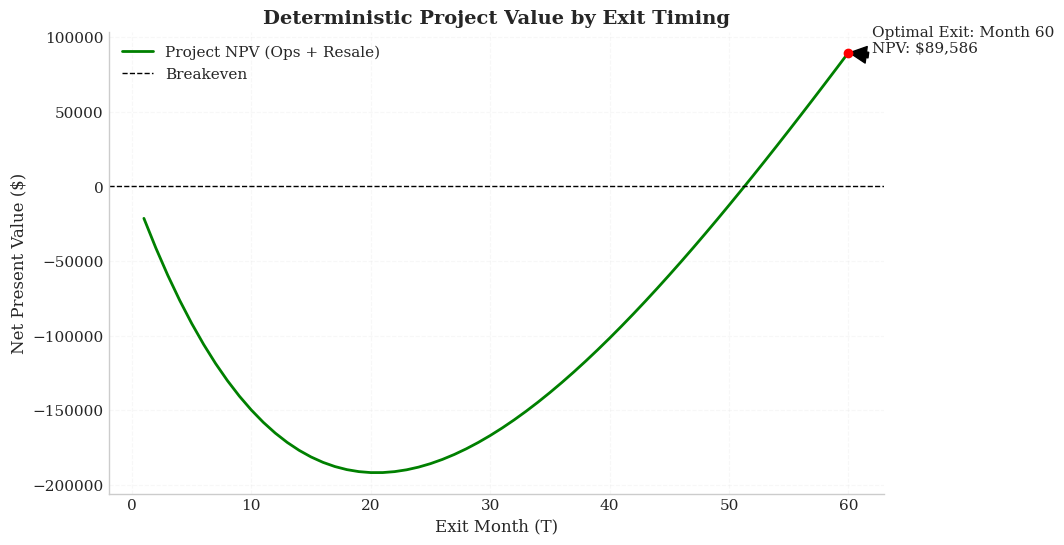

In [5]:
# --- Deterministic Project Value with Exit Strategy ---

# We assume the 'net_monthly_profit' calculated in the Base Case remains constant
n_months_proj = 5 * 12
projected_cfs = np.full(n_months_proj, net_monthly_profit)

# 2. Depreciation Parameters
# FIX: Use 'miner_price' instead of 'miner_cost'
miner_capex = n_miners * miner_price 
infra_capex = total_capex - miner_capex # This will be 0 in the Hybrid model, which is correct

depreciation_miner_monthly = 0.04  # 4% value loss per month
depreciation_infra_monthly = 0.01  # 1% value loss per month

possible_exits = np.arange(1, n_months_proj + 1)
pv_exit_curve = []

# Monthly Discount Rate (derived from annual rho)
# Fallback to 0.05 if other_params is not defined from previous cells
r_annual = other_params['rho'] if 'other_params' in locals() else 0.05
r_monthly = r_annual / 12

for T in possible_exits:
    # A. Discounted Cash Flows from operations (t=1 to T)
    cfs = projected_cfs[:T]
    discounts = (1 + r_monthly) ** np.arange(1, T + 1)
    pv_operations = np.sum(cfs / discounts)
    
    # B. Salvage Value at T (Discounted back to t=0)
    # Remaining Book Value
    rem_value_miners = miner_capex * ((1 - depreciation_miner_monthly) ** T)
    rem_value_infra = infra_capex * ((1 - depreciation_infra_monthly) ** T)
    salvage_value = rem_value_miners + rem_value_infra
    
    # Discount the salvage value received at time T
    pv_salvage = salvage_value / ((1 + r_monthly) ** T)
    
    # C. Total Project NPV if we stop at T
    total_npv = pv_operations + pv_salvage - total_capex
    pv_exit_curve.append(total_npv)

pv_exit_curve = np.array(pv_exit_curve)

# 3. Find Optimal Static Exit
optimal_exit_month = np.argmax(pv_exit_curve) + 1 
max_project_value = pv_exit_curve[optimal_exit_month - 1]
vs.plot_project_value(possible_exits, pv_exit_curve, max_project_value, optimal_exit_month)


exit_vars = {
    "StaticExitMonth": f"{optimal_exit_month}",
    "StaticMaxPV": f"{max_project_value:,.0f}",
    "SalvageDeprRate": f"{depreciation_miner_monthly*100:.0f}\\%"
}
export_params(exit_vars, "static_exit_analysis")

print(f"Optimal Stopping Time (Deterministic): Month {optimal_exit_month}")
print(f"Max Project Value: ${max_project_value:,.2f}")

## 4. Scenario 2: Stochastic Revenue: The "Hosting" Case

In this scenario, we isolate the value of **Revenue Volatility**.

**The Setup:**
* **Cost Structure:** We pay a fixed hosting rate ($0.065/kWh). This removes energy price risk but retains the obligation to pay for rack space.
* **Revenue Structure:** We are fully exposed to the volatility of **Bitcoin Price ($X_t$)** and **Hashprice ($Z_t$)**.
* **The Option:** The "Switching Option" here is the ability to turn off miners if the Hashprice drops below the hosting cost break-even point.

Before valuing this option, we must analyze the historical behavior of $X_t$ and $Z_t$ and simulate their future paths to ensure our model captures the "Crypto Winter" and "Bull Run" dynamics correctly.


### 4.1 Read Data

In [6]:
df_data = rd.read_data(data_path=data_path, is_electricity_constant=True)

Fetching data from Yahoo Finance...


In [7]:
# # Load Data (Now with Yahoo Finance online fetching enabled)
# # Start date is set, end_date=None means it will fetch up to "Today"
# df_data = rd.read_data(
#     data_path=data_path, 
#     is_electricity_constant=False, 
#     use_online_data=True,         # Set to False if you want to use purely local CSVs again
#     start_date='2020-01-01'       # Adjust as needed to match your Hashprice CSV
# )

# # # Filter for Training Period (Ensure valuation_date is set properly)
# # valuation_date = df_data.index[-1] # Automatically set valuation to the most recent day downloaded
# # n_train_days = 1000

# df_train = df_data[valuation_date - dt.timedelta(days=n_train_days): valuation_date]
# print(f"Loaded {len(df_train)} days of market data ending on {valuation_date.date()}")

In [8]:
n_simulations = 2000
n_days_forecast = other_parameters['projection_horizon']

n_train_days = 5 * 365 

Fetching data from Yahoo Finance...
Index(['btc', 'hashprice'], dtype='object')
True
  → Saved figure: c:\Users\fe_ma\Projects\MonteCarloHedge\results\figures\historical_bitcoin_dual.pdf


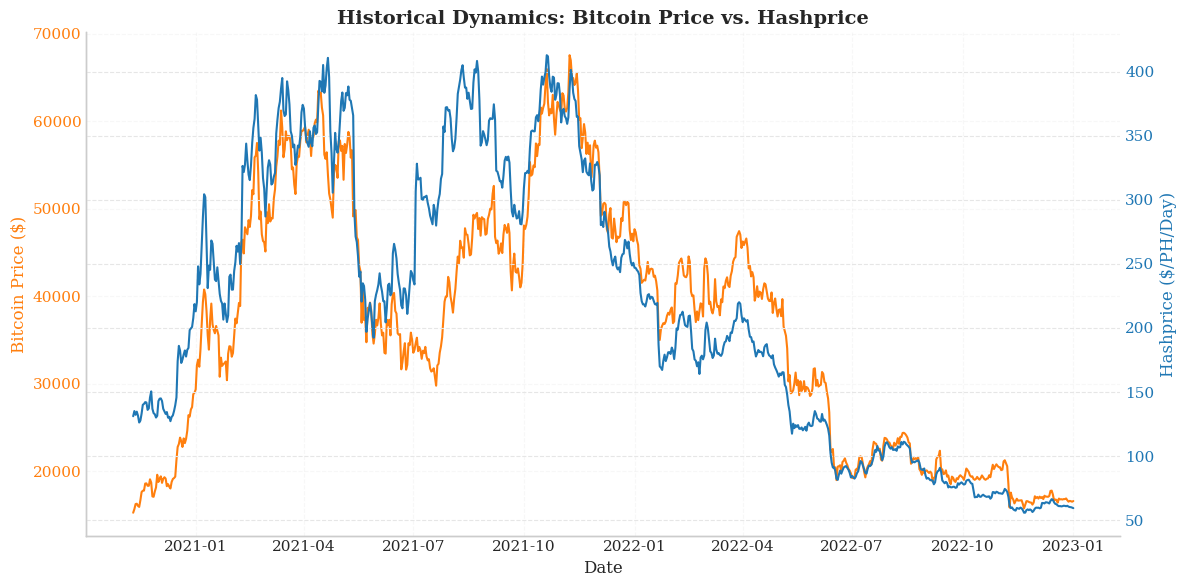

In [9]:
# --- 1. Load & Analyze Historical Data ---
# We load the data to calibrate our simulation
df_data = rd.read_data(data_path=data_path, is_electricity_constant=True)

# Filter for the training period (Calibration Window)
# We use the last N days to capture recent volatility regimes
df_train = df_data[valuation_date - dt.timedelta(days=n_train_days): valuation_date].copy()
vs.plot_prices(df_train)

In [10]:
# B. Correlation Analysis
# We need to see how tightly coupled they are (usually high correlation)
log_returns = np.log(df_train).diff().dropna()
corr_matrix = log_returns.corr()
btc_hash_corr = corr_matrix.loc['btc', 'hashprice']

print(f"--- Data Analysis ---")
print(f"Correlation (BTC vs Hashprice): {btc_hash_corr:.4f}")
print(f"Annual Volatility (BTC):       {log_returns['btc'].std() * np.sqrt(365):.2%}")
print(f"Annual Volatility (Hashprice): {log_returns['hashprice'].std() * np.sqrt(365):.2%}")

# Export Calibration Stats
stats_vars = {
    "CorrBTCHash": f"{btc_hash_corr:.2f}",
    "VolBTC": f"{log_returns['btc'].std() * np.sqrt(365):.1%}",
    "VolHash": f"{log_returns['hashprice'].std() * np.sqrt(365):.1%}"
}
export_params(stats_vars, "revenue_calibration")

--- Data Analysis ---
Correlation (BTC vs Hashprice): 0.4937
Annual Volatility (BTC):       72.56%
Annual Volatility (Hashprice): 74.85%
  → Saved params: c:\Users\fe_ma\Projects\MonteCarloHedge\results\revenue_calibration.json
  → Saved macros: c:\Users\fe_ma\Projects\MonteCarloHedge\results\tables\revenue_calibration_macros.tex


('c:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\results\\revenue_calibration.json',
 'c:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\results\\tables\\revenue_calibration_macros.tex')

### 4.2 Simulations

In [11]:
# --- 2. Simulation (Stochastic Revenue) ---
# We simulate thousands of potential future paths for X and Z

# Calibrate Multivariate GBM Parameters
multi_params = sm.calculate_multivariate_params(log_returns)

# Run Simulation
# We assume Electricity is constant (not simulated here, or simulated but ignored later)
# The simulation function returns a dictionary of paths (N_sims x N_days)
print(f"\nSimulating {n_simulations} paths over {n_days_forecast} days...")
sim_results = sm.simulate_multivariate_with_electricity(
    multivariate_params=multi_params,
    n_days=n_days_forecast,
    electricity_params=None, # Electricity not needed for this step (or handled separately)
    n_simulations=n_simulations,
    start_date=valuation_date
)
price_simulations = sm.convert_to_price(sim_results, df_train)


Simulating 2000 paths over 1917 days...


  → Saved figure: c:\Users\fe_ma\Projects\MonteCarloHedge\results\figures\simulated_revenue_paths.pdf


'c:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\results\\figures\\simulated_revenue_paths.pdf'

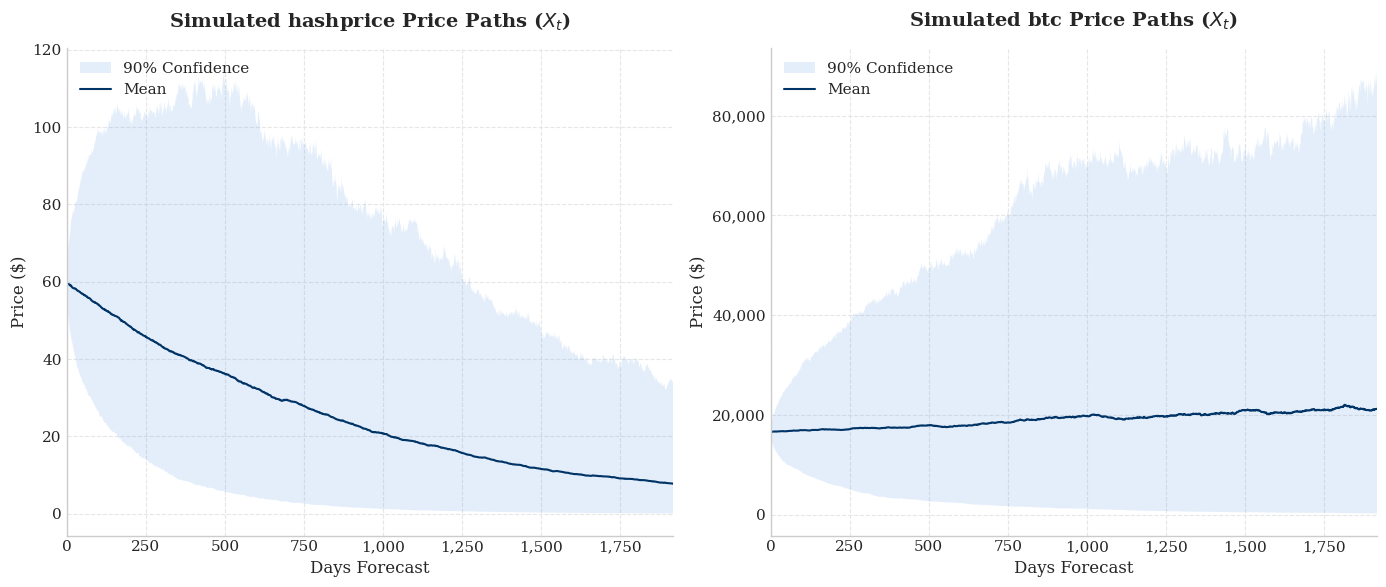

In [12]:
# --- 3. Visualization: Simulation Fan Charts ---
# We plot the 50% (median) and 90% confidence intervals to show the risk range.

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, name in enumerate(prices):
    # Plot BTC Simulation
    vs.plot_distribution(
        x_values=np.arange(n_days_forecast + 1),
        data=prices[name],
        title=f"Simulated {name} Price Paths ($X_t$)",
        ylabel="Price ($)",
        xlabel="Days Forecast",
        ax=axes[i]
    )

plt.tight_layout()
export_figure(fig, "simulated_revenue_paths")

-----------hashprice-----------
Axes(0.125,0.11;0.775x0.77)
-----------btc-----------
Axes(0.125,0.11;0.775x0.77)
-----------electricity-----------
Axes(0.125,0.11;0.775x0.77)


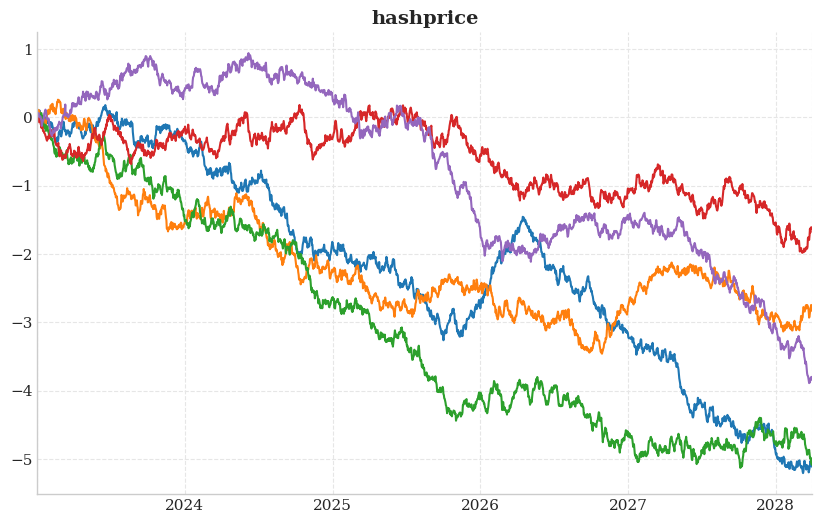

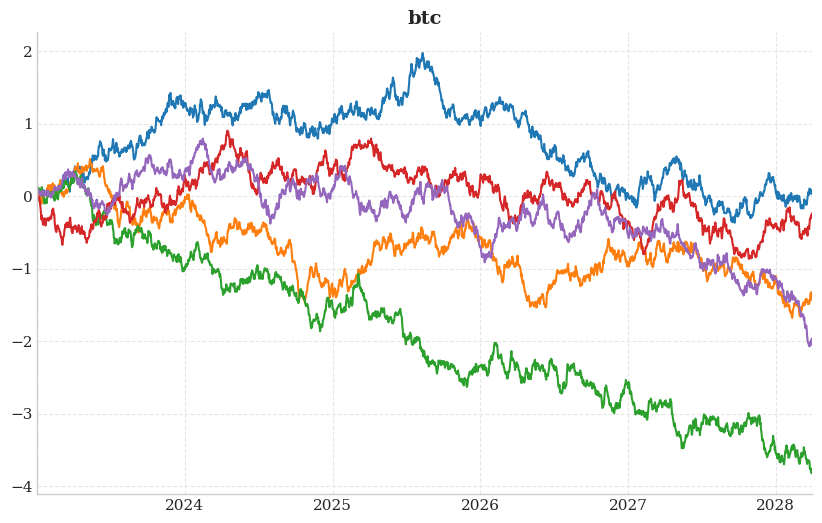

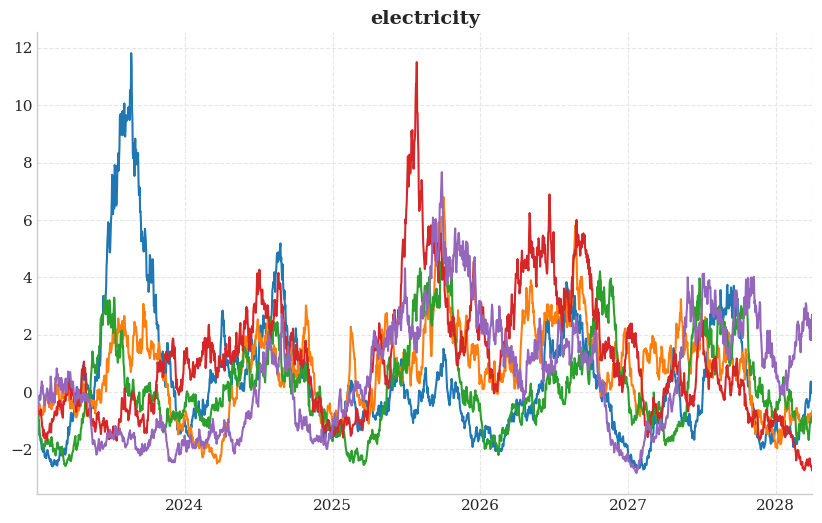

In [59]:
# price_simulations
# for asset, price_sim in price_simulations.items():
#     print(asset)
if 'hashprice' in prices:
    prices['hashprice'] *= total_hashrate_ph

# Convert log-returns to Price Paths
projection_horizon = other_parameters['projection_horizon']
list_dates = [valuation_date + dt.timedelta(days=i) for i in range(projection_horizon + 1)]
# print(len(list_dates))

prices = {}
delta_prices = {}
btc_assets = ['hashprice', 'btc']
for name, price in price_simulations.items():
    print('-----------'+name+'-----------')
    prices[name] = pd.DataFrame(price_simulations[name], columns=list_dates)
    delta_prices[name] = prices[name].T
    if name in btc_assets:
        delta_prices[name] = np.log(delta_prices[name])
    delta_prices[name] = delta_prices[name].diff().dropna()
    delta_prices[name] = delta_prices[name].rolling(len(delta_prices[name]), min_periods=1).sum()

    delta_prices[name] = delta_prices[name].T
    print(delta_prices[name].head().T.plot(title=name, legend=False))

Parameters

In [ ]:
# We use a constant scalar for Y
fixed_elec_price = hosting_rate_kwh # e.g. 0.065
prices['electricity'] = fixed_elec_price
other_parameters['n_days_forecast'] = projection_horizon
other_parameters['delta_time'] = 1 / 365.25


### 4.3 Calculate G function

In [14]:
kappa = investment_parameters['kappa']
k = investment_parameters['k']
K = investment_parameters['K']

rho = other_parameters['rho']
delta_time = other_parameters['delta_time']
project_duration = other_parameters['project_duration']

print(rho, project_duration, project_duration / 365.25, rho * project_duration / 365.25)

print(np.exp(-rho * project_duration / 365.25))
print(K, k)
# (k / rho) * (np.exp(-rho * project_duration / 365.25) - 1)


0.05 1826 4.999315537303217 0.2499657768651609
0.7788274365316966
875000 0


In [15]:

kappa = investment_parameters['kappa']
k = investment_parameters['k']
K = investment_parameters['K']

rho = other_parameters['rho']
delta_time = other_parameters['delta_time']
project_duration = other_parameters['project_duration']

g_value = 0

for i_aux in range(1, project_duration + 1):
    end_date = date + dt.timedelta(days=i_aux)
    delta_x = prices['hashprice'][end_date] - prices['hashprice'][date]
    
    if isinstance(prices['electricity'], (pd.DataFrame, pd.Series)):
            delta_y = prices['electricity'][end_date] - prices['electricity'][date]
    else:
            delta_y = 0

    g_aux = x0 + delta_x - kappa * (y0 + delta_y)
    g_aux[g_aux < 0] = 0
    g_aux -= k
    g_aux *= np.exp(-rho * i_aux * delta_time) * delta_time
    g_value += g_aux.mean()

NameError: name 'date' is not defined

In [ ]:
def calculate_g_montecarlo(x0, y0, date, prices, delta_prices, investment_parameters, other_parameters):
    """
    Performs a Monte Carlo simulation to estimate the g value for a specific state.

    Parameters:
    x0 (float): Initial Hashprice.
    y0 (float): Initial Electricity price.
    date (datetime): Current date.
    prices (dict): Dictionary containing price DataFrames.
    investment_parameters (dict): Investment parameters.
    other_parameters (dict): Other parameters.

    Returns:
    float: The estimated g value (NPV - K).
    """

    kappa = investment_parameters['kappa']
    k = investment_parameters['k']
    K = investment_parameters['K']

    rho = other_parameters['rho']
    delta_time = other_parameters['delta_time']
    project_duration = other_parameters['project_duration']
    dates = [date + dt.timedelta(days=i_aux) for i_aux in range(1, project_duration + 1)]
    discount_factor = [np.exp(-rho * i * delta_time) * delta_time for i in range(1, project_duration + 1)]

    delta_x = delta_prices['hashprice'][dates] - 

    
    df_repeated = pd.concat([prices['hashprice'][date]] * len(dates), axis=1)
    df_repeated.columns = dates
    delta_x = prices['hashprice'][dates] - df_repeated 

    if isinstance(prices['electricity'], (pd.DataFrame, pd.Series)):  
        df_repeated = pd.concat([prices['electricity'][date]] * len(dates), axis=1)
        df_repeated.columns = dates
        delta_y = prices['electricity'][dates] - df_repeated 
    else:
        delta_y = 0
     
    g_aux = x0 + delta_x - kappa * (y0 + delta_y)
    df_discount_factor = pd.DataFrame(discount_factor, index=dates)
    df_discount_factor = df_discount_factor.T
    df_discount_factor = pd.concat([df_discount_factor] * len(g_aux))
    # print(df_discount_factor.shape)
    # print(g_aux.shape)

    g_aux = g_aux * df_discount_factor
    g_aux[g_aux < 0] = 0
    g_aux -= k
    # print(g_aux.shape)
    # print(g_aux.sum(axis=1).shape)
    # print(g_aux.sum(axis=1).mean())

    g_value = g_aux.sum(axis=1).mean()
    
    return float(g_value)
#     df_repeated = pd.concat(repeated_columns, axis=1)

#     g_value = 0
#     g_value_a = 0
#     for i_aux in range(1, project_duration + 1):
#         end_date = date + dt.timedelta(days=i_aux)
#         delta_x = prices['hashprice'][end_date] - prices['hashprice'][date]
        
#         if isinstance(prices['electricity'], (pd.DataFrame, pd.Series)):
#              delta_y = prices['electricity'][end_date] - prices['electricity'][date]
#         else:
#              delta_y = 0

#         g_aux = x0 + delta_x - kappa * (y0 + delta_y)
#         g_aux[g_aux < 0] = 0
#         g_aux -= k
#         g_aux *= np.exp(-rho * i_aux * delta_time) * delta_time
#         g_value += g_aux.mean()

#      #    g_aux_a = x0 + delta_x - kappa * (y0 + delta_y)
#      #    g_aux_a -= k
#      #    g_aux_a *= np.exp(-rho * i_aux * delta_time) * delta_time

#      #    g_value_a += g_aux_a.mean()
#     return float(g_value)


In [18]:
import random
n_simulations = 500
b = []
A = []
kappa = investment_parameters['kappa']
valuation_date = other_parameters['valuation_date']
n_days_forecast = other_parameters['n_days_forecast']
project_duration = other_parameters['project_duration']

list_dates = [valuation_date + dt.timedelta(days=i) for i in range(n_days_forecast + 1 - project_duration)]

for _ in range(n_simulations):
    i = random.choice(range(len(prices['hashprice'])))
    date = random.choice(list_dates)

    x0 = prices['hashprice'].loc[i][date]

    if isinstance(prices['electricity'], (pd.DataFrame, pd.Series)):
        y0 = prices['electricity'].loc[i][date]
    else:
        y0 = prices['electricity']

    g0 = calculate_g_montecarlo(x0, y0, date, prices, investment_parameters, other_parameters)
    v0 = x0 - kappa * y0
    b.append(g0)
    A.append([1, v0, v0**2, v0**3])

mt_A = np.matrix(A)
# print('mt_A', mt_A.shape)
# print(mt_A)

mt_b = np.matrix(b).T
# print('mt_b', mt_b.shape)
# print(mt_b)

mt_A_inv = np.linalg.inv(mt_A.T @ mt_A)
mt_alpha = mt_A_inv @ (mt_A.T @ mt_b)


In [19]:
g_results = pd.DataFrame()
col_aux = []
for i in range(10):
# for date_aux in prices['hashprice'].columns:

    date_aux = random.choice(prices['hashprice'].columns)
    if date_aux in col_aux:
        continue
    col_aux.append(date_aux)

    # Reformat the prices structure for that specific date so it works with the function
    df_prices_g = op.obtain_prices(prices, date_aux)

    # Calculate the g_tilde results using the already estimated g_alpha coefficients
    g_tilde_results = gf.calculate_g_tilde(df_prices_g, investment_parameters['kappa'], mt_alpha)
    g_results = pd.concat([g_results, g_tilde_results], axis=1)
    # print(f"g_tilde results for {date_aux.date()}:")
    # Display the first few rows of the calculation for review
    # display(g_tilde_results.to_frame(name='g_tilde').head())
# g_results.columns = prices['hashprice'].columns
g_results.columns = col_aux



<Axes: >

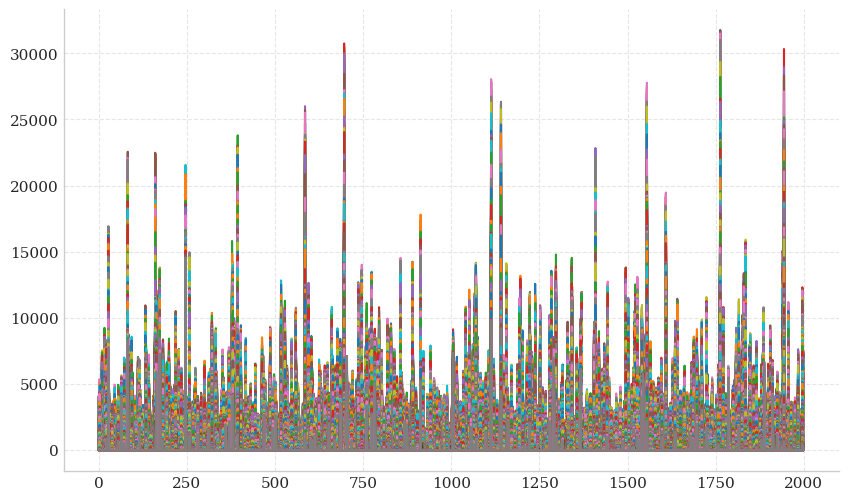

In [20]:
project_duration = other_parameters['project_duration']

kappa = investment_parameters['kappa']
k = investment_parameters['k']
K = investment_parameters['K']

result_aux = prices['hashprice'] - kappa * prices['electricity'] - k
result_aux = result_aux.T
result_aux[result_aux < 0] = 0
result_aux -= k
result_total = result_aux.rolling(project_duration).sum()
result_total = result_total.shift(-project_duration)
result_total.dropna(inplace=True)

# result_total
# (result_total - K).dropna().plot(legend=False)
# (result_total - K).T.describe()
(result_total).T.describe()


# result_aux
result_aux.T.plot(legend=False)

<Axes: >

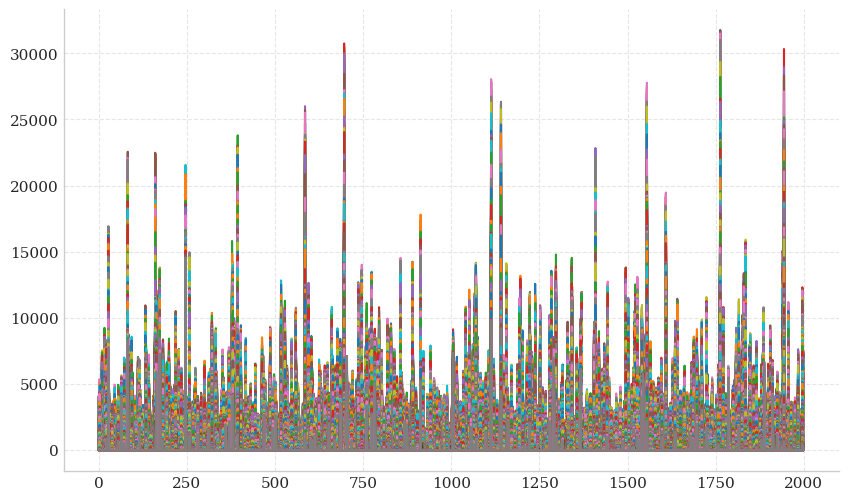

In [21]:
result_aux.T.plot(legend=False)

In [22]:
# 3. Estimate G-Function Coefficients (Alpha)
# This trains the model to understand how daily profit maps to long-term NPV
print("Estimating G-Function Coefficients (Project Value Mapping)...")

g_alpha = gf.estimate_g_alpha(
    prices=prices,
    # dates_parameters=other_parameters,
    investment_parameters=investment_parameters,
    other_parameters=other_parameters,
    n_simulations=100
)

print(f"G-Function Alphas: {g_alpha.flatten()}")

Estimating G-Function Coefficients (Project Value Mapping)...
G-Function Alphas: [[-8.73976982e+05 -1.25583643e-01  8.50643142e-04 -4.86407831e-08]]


In [23]:
import src.options as op
import src.g_functions as gf

# Select a date to evaluate (e.g., the valuation date from your other_parameters)
test_date = other_parameters['valuation_date']

# Reformat the prices structure for that specific date so it works with the function
df_prices_g = op.obtain_prices(prices, test_date)

# Calculate the g_tilde results using the already estimated g_alpha coefficients
g_tilde_results = gf.calculate_g_tilde(df_prices_g, investment_parameters['kappa'], g_alpha)

print(f"g_tilde results for {test_date.date()}:")
# Display the first few rows of the calculation for review
display(g_tilde_results.to_frame(name='g_tilde').head())


g_tilde results for 2023-01-01:


,g_tilde
0,-872867.486481
1,-872867.486481
2,-872867.486481
3,-872867.486481
4,-872867.486481


In [24]:
# stop

### 4.4 Real Option Value

In [25]:
# 4. Run Real Option Valuation (LSMC)
print("Calculating Real Option Value (Fixed Power Cost)...")
dates_window = [valuation_date + dt.timedelta(days=i) for i in range(n_days_forecast + 1)]
basis_config = {'pol_order': 2, 'option_basis': 'black-scholes'}
results_fixed = op.calculate_real_option(
    prices=prices, 
    other_parameters=other_parameters,
    investment_parameters=investment_parameters,
    basis_type=basis_config,
    g_alpha=g_alpha
)

Calculating Real Option Value (Fixed Power Cost)...
--------------------
[datetime.datetime(2023, 1, 1, 0, 0), datetime.datetime(2023, 1, 31, 0, 0), datetime.datetime(2023, 3, 2, 0, 0), datetime.datetime(2023, 4, 2, 0, 0)]
[datetime.datetime(2023, 1, 1, 0, 0), datetime.datetime(2023, 1, 31, 0, 0), datetime.datetime(2023, 3, 2, 0, 0)]
--------------------
date 2023-03-02 00:00:00
date 2023-01-31 00:00:00
   call_po_0  call_po_1_btc  call_po_2_btc  call_option  dl_po_0_btc  \
0          1   -1776.843722   3.157174e+06  3994.515355  -813.047414   
1          1   -2626.482175   6.898409e+06  3497.659678  8975.703965   
2          1   -2279.411581   5.195717e+06  3697.619003  1085.143066   
3          1   -6359.069399   4.043776e+07  1646.382563  -401.651772   
4          1   -1923.218585   3.698770e+06  3907.164020 -3730.470837   

    dl_po_1_btc  dl_option_btc  
0  1.444658e+06    -487.175125  
1 -2.357453e+07    5116.255076  
2 -2.473488e+06     631.765917  
3  2.554131e+06    -166.3564

### 4.5 Results

  → Saved figure: c:\Users\fe_ma\Projects\MonteCarloHedge\results\figures\ro_value_fixed_cost.pdf
  → Saved params: c:\Users\fe_ma\Projects\MonteCarloHedge\results\ro_results_fixed.json
  → Saved macros: c:\Users\fe_ma\Projects\MonteCarloHedge\results\tables\ro_results_fixed_macros.tex
--- Results (Fixed Power) ---
Real Option Value: $0
Intrinsic NPV:     $0
Option Premium:    $0 (Value of Flexibility)


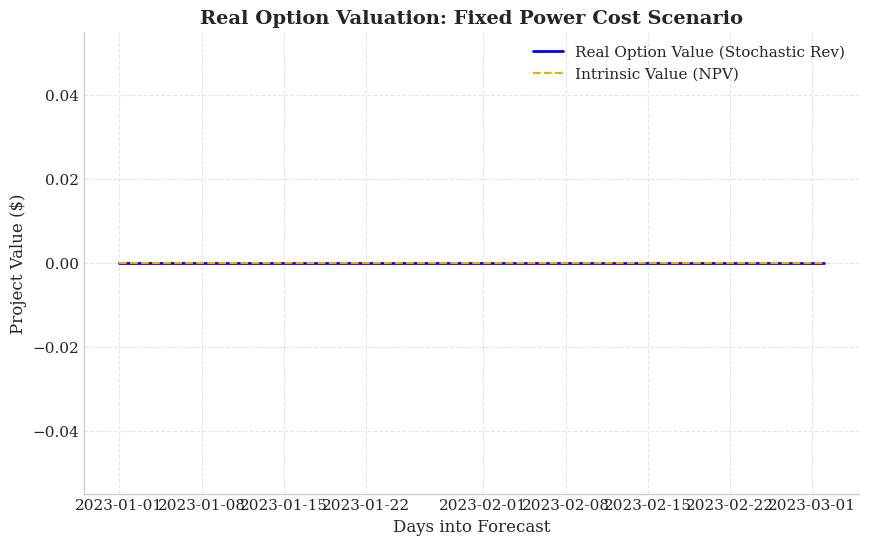

In [26]:
df_ro_fixed = results_fixed[0] # Option Value
df_int_fixed = results_fixed[2] # Intrinsic Value (NPV)

# 5. Visualize Results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Mean Option Value vs Mean Intrinsic Value over time
ax.plot(df_ro_fixed.mean(axis=0), label="Real Option Value (Stochastic Rev)", color='blue', linewidth=2)
ax.plot(df_int_fixed.mean(axis=0), label="Intrinsic Value (NPV)", color='orange', linestyle='--')

ax.set_title("Real Option Valuation: Fixed Power Cost Scenario")
ax.set_ylabel("Project Value ($)")
ax.set_xlabel("Days into Forecast")
ax.legend()

export_figure(fig, "ro_value_fixed_cost")

# 6. Export Key Metrics
ro_val_t0 = df_ro_fixed.iloc[0, 0]
int_val_t0 = df_int_fixed.iloc[0, 0]
option_premium = ro_val_t0 - int_val_t0

fixed_cost_results = {
    "FixedPowerROValue": f"{ro_val_t0:,.0f}",
    "FixedPowerNPV": f"{int_val_t0:,.0f}",
    "FixedPowerPremium": f"{option_premium:,.0f}"
}
export_params(fixed_cost_results, "ro_results_fixed")

print(f"--- Results (Fixed Power) ---")
print(f"Real Option Value: ${ro_val_t0:,.0f}")
print(f"Intrinsic NPV:     ${int_val_t0:,.0f}")
print(f"Option Premium:    ${option_premium:,.0f} (Value of Flexibility)")


## 5. Scenario 3: Full Stochastic: Revenue and Cost

#### 3.1 Read Data

In [27]:
df_data = rd.read_data(data_path=data_path, is_electricity_constant=False)

Fetching data from Yahoo Finance...


In [28]:
n_simulations = 500
n_days_forecast = other_parameters['projection_horizon']

n_train_days = 5 * 365 

In [29]:
df_data.describe()

,btc,hashprice,electricity
count,1821.000000,1821.000000,1821.000000
mean,52416.122071,128.834355,3.737700
std,29359.537821,103.754104,1.730998
min,15290.902344,37.700000,1.575000
25%,28307.597656,57.560000,2.590000
50%,43840.285156,77.460000,3.097000
75%,66710.156250,180.630000,4.247000
max,124752.531250,412.850000,9.680000


Index(['btc', 'hashprice', 'electricity'], dtype='object')
True
  → Saved figure: c:\Users\fe_ma\Projects\MonteCarloHedge\results\figures\historical_electricity_dual.pdf


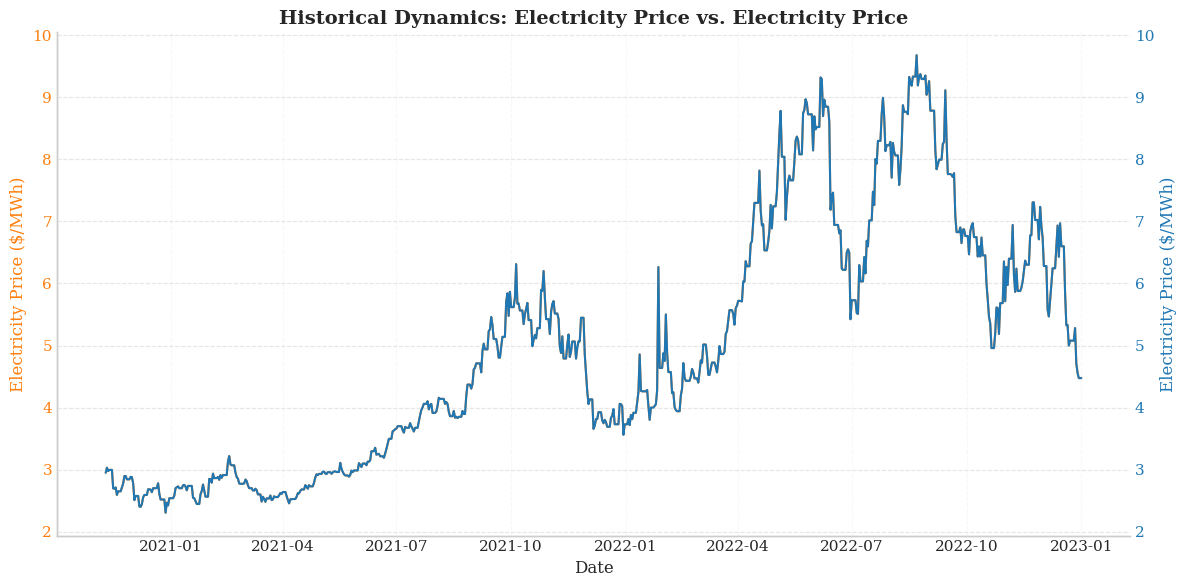

In [30]:
# --- 1. Load & Analyze Historical Data ---
# We load the data to calibrate our simulation

# Filter for the training period (Calibration Window)
# We use the last N days to capture recent volatility regimes
df_train = df_data[valuation_date - dt.timedelta(days=n_train_days): valuation_date].copy()
vs.plot_prices(df_train, assets_type='electricity')

In [31]:
# B. Correlation Analysis
# We need to see how tightly coupled they are (usually high correlation)
df_data_ret = np.log(df_train)
df_data_ret[['hashprice', 'btc']] = df_data_ret[['hashprice', 'btc']].diff()
df_data_ret.dropna(inplace=True)

corr_matrix = df_data_ret.corr()

assets = ['btc', 'hashprice']

corr = corr_matrix.loc[assets[0], assets[1]]

print(f"--- Data Analysis ---")
print(f"Correlation ({assets[0].capitalize()} vs {assets[1].capitalize()}): {corr:.4f}")
print(f"Annual Volatility ({assets[0].capitalize()}):       {df_data_ret[assets[0]].std() * np.sqrt(365):.2%}")
print(f"Annual Volatility ({assets[1].capitalize()}): {df_data_ret[assets[1]].std() * np.sqrt(365):.2%}")

# Export Calibration Stats
stats_vars = {
    "CorrBTCHash": f"{corr:.2f}",
    "VolBTC": f"{df_data_ret[assets[0]].std() * np.sqrt(365):.1%}",
    "VolHash": f"{df_data_ret[assets[1]].std() * np.sqrt(365):.1%}"
}
export_params(stats_vars, "revenue_calibration")

--- Data Analysis ---
Correlation (Btc vs Hashprice): 0.4937
Annual Volatility (Btc):       72.56%
Annual Volatility (Hashprice): 74.85%
  → Saved params: c:\Users\fe_ma\Projects\MonteCarloHedge\results\revenue_calibration.json
  → Saved macros: c:\Users\fe_ma\Projects\MonteCarloHedge\results\tables\revenue_calibration_macros.tex


('c:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\results\\revenue_calibration.json',
 'c:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\results\\tables\\revenue_calibration_macros.tex')

#### 3.2 Simulations

In [32]:
# --- 2. Simulation (Stochastic Revenue) ---
# We simulate thousands of potential future paths for X and Z

# Calibrate Multivariate GBM Parameters
# fit_models = {'hashprice': 'brownian', 'btc': 'brownian', 'electricity': 'fit_electricity'}

multi_params = sm.calculate_multivariate_params(df_data_ret)
df_electricity, electricity_params = sm.fit_electricity(df_data_ret)

# Run Simulation
# We assume Electricity is constant (not simulated here, or simulated but ignored later)
# The simulation function returns a dictionary of paths (N_sims x N_days)
print(f"\nSimulating {n_simulations} paths over {n_days_forecast} days...")
sim_results = sm.simulate_multivariate_with_electricity(
    multivariate_params=multi_params,
    n_days=n_days_forecast,
    electricity_params=electricity_params, 
    n_simulations=n_simulations,
    start_date=valuation_date
)
price_simulations = sm.convert_to_price(sim_results, df_train)


Simulating 500 paths over 1917 days...


  → Saved figure: c:\Users\fe_ma\Projects\MonteCarloHedge\results\figures\simulated_revenue_paths.pdf


'c:\\Users\\fe_ma\\Projects\\MonteCarloHedge\\results\\figures\\simulated_revenue_paths.pdf'

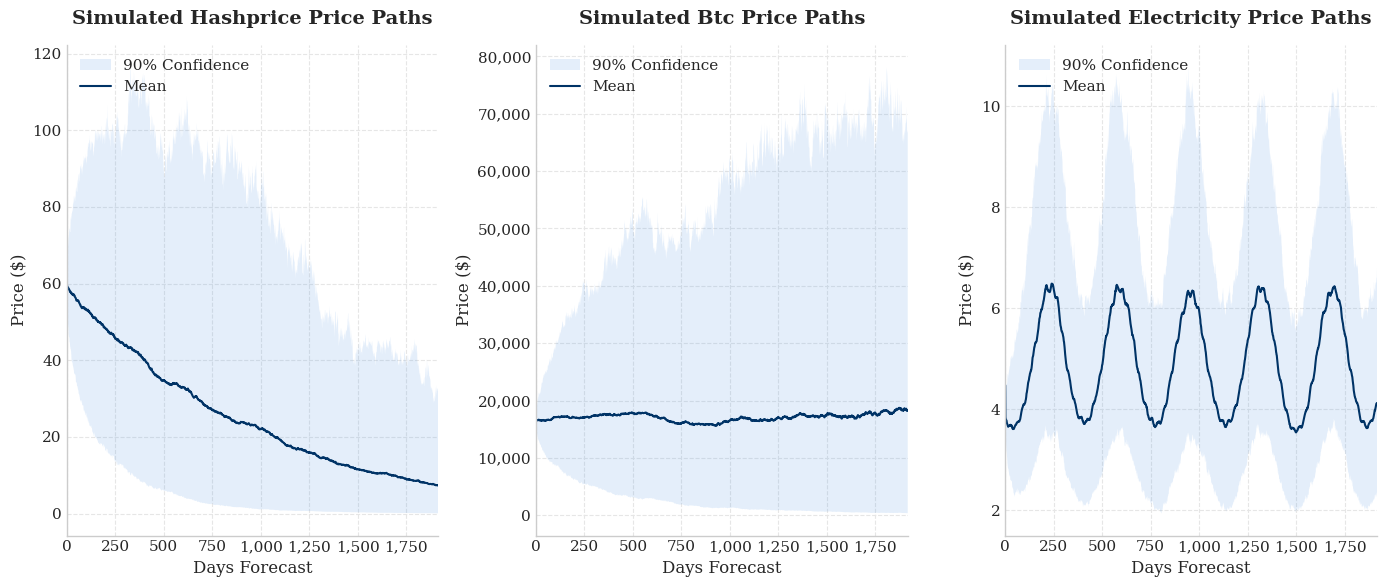

In [33]:
# Convert log-returns to Price Paths
projection_horizon = other_parameters['projection_horizon']
list_dates = list_dates = [valuation_date + dt.timedelta(days=i) for i in range(projection_horizon + 1)]

prices = {}
for name, price in price_simulations.items():
    prices[name] = pd.DataFrame(price_simulations[name], columns=list_dates)

# --- 3. Visualization: Simulation Fan Charts ---
# We plot the 50% (median) and 90% confidence intervals to show the risk range.

fig, axes = plt.subplots(1, len(prices), figsize=(14, 6))

for i, name in enumerate(prices):
    # Plot BTC Simulation
    # print('-'*20 + name + '-'*20)
    # print(prices[name].describe())

    # print(name, prices[name].head())
    vs.plot_distribution(
        x_values=np.arange(n_days_forecast + 1),
        data=prices[name],
        title=f"Simulated {name.capitalize()} Price Paths",
        ylabel="Price ($)",
        xlabel="Days Forecast",
        ax=axes[i]
    )

plt.tight_layout()
export_figure(fig, "simulated_revenue_paths")

Parameters

In [34]:
other_parameters['n_days_forecast'] = projection_horizon
other_parameters['delta_time'] = 1 / 365.25
if 'hashprice' in prices:
    prices['hashprice'] *= total_hashrate_ph

if 'electricity' in prices:
    prices['electricity'] /= 10000

#### 3.3 Calculate G function

In [35]:
n_simulations = 2000

b = []
A = []
kappa = investment_parameters['kappa']
valuation_date = other_parameters['valuation_date']
n_days_forecast = other_parameters['n_days_forecast']
project_duration = other_parameters['project_duration']

list_dates = [valuation_date + dt.timedelta(days=i) for i in range(n_days_forecast + 1 - project_duration)]

for _ in range(n_simulations):
    i = random.choice(range(len(prices['hashprice'])))
    date = random.choice(list_dates)

    x0 = prices['hashprice'].loc[i][date]

    if isinstance(prices['electricity'], (pd.DataFrame, pd.Series)):
        y0 = prices['electricity'].loc[i][date]
    else:
        y0 = prices['electricity']

    g0 = calculate_g_montecarlo(x0, y0, date, prices, investment_parameters, other_parameters)
    v0 = x0 - kappa * y0
    b.append(g0)
    A.append([1, v0, v0**2, v0**3])

mt_A = np.matrix(A)
# print('mt_A', mt_A.shape)
# print(mt_A)

mt_b = np.matrix(b).T
# print('mt_b', mt_b.shape)
# print(mt_b)

mt_A_inv = np.linalg.inv(mt_A.T @ mt_A)
mt_alpha = mt_A_inv @ (mt_A.T @ mt_b)


In [36]:
g_results = pd.DataFrame()
col_aux = []
for i in range(10):
# for date_aux in prices['hashprice'].columns:

    date_aux = random.choice(prices['hashprice'].columns)
    if date_aux in col_aux:
        continue
    col_aux.append(date_aux)

    # Reformat the prices structure for that specific date so it works with the function
    df_prices_g = op.obtain_prices(prices, date_aux)

    # Calculate the g_tilde results using the already estimated g_alpha coefficients
    g_tilde_results = gf.calculate_g_tilde(df_prices_g, investment_parameters['kappa'], mt_alpha)
    g_results = pd.concat([g_results, g_tilde_results], axis=1)
    # print(f"g_tilde results for {date_aux.date()}:")
    # Display the first few rows of the calculation for review
    # display(g_tilde_results.to_frame(name='g_tilde').head())
# g_results.columns = prices['hashprice'].columns
g_results.columns = col_aux

In [37]:
# g_results.columns.sort_values()
K

875000

<Axes: >

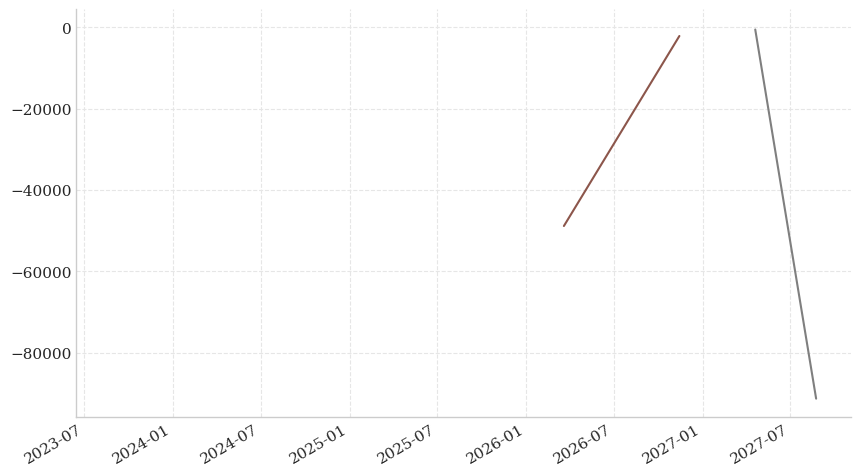

In [38]:
# legend=False
# g_results.tail(50)
g_results = g_results[g_results.columns.sort_values()]

g_results[g_results > 0] = np.nan
g_results.T.plot(legend=False)


In [39]:
g_results.describe()

,2023-02-04,2023-06-12,2023-07-29,2023-07-30,2023-08-27,2026-03-20,2026-11-14,2026-12-02,2027-04-20,2027-08-24
count,0.0,0.0,0.0,0.0,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000
mean,NaN,NaN,NaN,NaN,-7308.854286,-27070.962970,-2121.298156,-980.370093,-527.992841,-69955.869078
std,NaN,NaN,NaN,NaN,10204.314118,30772.372002,NaN,NaN,NaN,30147.758804
min,NaN,NaN,NaN,NaN,-14524.393996,-48830.315886,-2121.298156,-980.370093,-527.992841,-91273.553766
25%,NaN,NaN,NaN,NaN,-10916.624141,-37950.639428,-2121.298156,-980.370093,-527.992841,-80614.711422
50%,NaN,NaN,NaN,NaN,-7308.854286,-27070.962970,-2121.298156,-980.370093,-527.992841,-69955.869078
75%,NaN,NaN,NaN,NaN,-3701.084431,-16191.286513,-2121.298156,-980.370093,-527.992841,-59297.026733
max,NaN,NaN,NaN,NaN,-93.314576,-5311.610055,-2121.298156,-980.370093,-527.992841,-48638.184389


In [40]:
delta_time = other_parameters['delta_time']
delta_time * 365.25

1.0

In [41]:
kappa = investment_parameters['kappa']
k = investment_parameters['k']
K = investment_parameters['K']

rho = other_parameters['rho']
delta_time = other_parameters['delta_time']
project_duration = other_parameters['project_duration']

print(rho, project_duration, project_duration / 365.25, rho * project_duration / 365.25)

print(np.exp(-rho * project_duration / 365.25))
print(K, k)
# (k / rho) * (np.exp(-rho * project_duration / 365.25) - 1)



0.05 1826 4.999315537303217 0.2499657768651609
0.7788274365316966
875000 0


In [42]:
# 3. Estimate G-Function Coefficients (Alpha)
# This trains the model to understand how daily profit maps to long-term NPV
print("Estimating G-Function Coefficients (Project Value Mapping)...")

g_alpha = gf.estimate_g_alpha(
    prices=prices,
    # dates_parameters=other_parameters,
    investment_parameters=investment_parameters,
    other_parameters=other_parameters,
    n_simulations=500
)

print(f"G-Function Alphas: {g_alpha.flatten()}")

Estimating G-Function Coefficients (Project Value Mapping)...
G-Function Alphas: [[-8.71811994e+05 -2.36269361e+00  1.53725423e-03 -1.11113101e-07]]


In [43]:
import src.options as op
import src.g_functions as gf

# Select a date to evaluate (e.g., the valuation date from your other_parameters)
test_date = other_parameters['valuation_date']

g_results = pd.DataFrame()

for date_aux in prices['hashprice'].columns:

    # Reformat the prices structure for that specific date so it works with the function
    df_prices_g = op.obtain_prices(prices, date_aux)

    # Calculate the g_tilde results using the already estimated g_alpha coefficients
    g_tilde_results = gf.calculate_g_tilde(df_prices_g, investment_parameters['kappa'], g_alpha)
    g_results = pd.concat([g_results, g_tilde_results], axis=1)
    # print(f"g_tilde results for {date_aux.date()}:")
    # Display the first few rows of the calculation for review
    # display(g_tilde_results.to_frame(name='g_tilde').head())
g_results.columns = prices['hashprice'].columns


In [44]:
# Calculate g_tilde across the entire price path dataframe using broadcasting
v = prices['hashprice'] - investment_parameters['kappa'] * prices['electricity']
g_tilde_all = g_alpha[0].item() + g_alpha[1].item() * v + g_alpha[2].item() * v**2 + g_alpha[3].item() * v**3

print("g_tilde results across all paths:")
display(g_tilde_all.head())


g_tilde results across all paths:


,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08,2023-01-09,2023-01-10,...,2028-03-23,2028-03-24,2028-03-25,2028-03-26,2028-03-27,2028-03-28,2028-03-29,2028-03-30,2028-03-31,2028-04-01
0,-868444.439885,-868311.636100,-868567.918966,-868673.141811,-867948.259920,-867455.884369,-867210.393126,-867291.248609,-867904.024281,-867940.877699,...,-871825.353892,-871826.538619,-871827.546779,-871829.237385,-871828.486501,-871826.408333,-871825.027620,-871827.233361,-871827.971089,-871826.665354
1,-868444.439885,-868544.990878,-868224.710138,-867925.936053,-867107.873254,-867389.875299,-867365.263747,-868545.204981,-868755.477219,-868809.537800,...,-872150.999751,-872125.434962,-872130.666998,-872146.860688,-872158.208740,-872172.022735,-872183.666310,-872182.232630,-872161.345417,-872153.007738
2,-868444.439885,-869075.999662,-868728.812674,-868576.133081,-868248.255983,-868317.291016,-868447.677195,-868069.855448,-868263.293010,-867993.616843,...,-871846.048996,-871846.953668,-871843.394869,-871838.811297,-871838.185410,-871838.225659,-871834.369892,-871833.871834,-871832.853530,-871836.141840
3,-868444.439885,-869168.495526,-869189.300481,-868814.365643,-868194.805499,-868168.439770,-868569.690743,-869124.169499,-869098.016303,-869367.881331,...,-872616.959081,-872603.146066,-872630.995387,-872674.783948,-872652.526962,-872683.820746,-872679.416647,-872680.855917,-872685.729576,-872676.708218
4,-868444.439885,-868284.331492,-867723.463747,-867878.384525,-867714.499498,-868146.159569,-868413.699846,-868239.832868,-868268.665657,-868368.111593,...,-871912.917150,-871909.794746,-871909.497645,-871913.656445,-871921.155107,-871921.850610,-871924.406154,-871920.529657,-871913.814336,-871920.972149


#### 3.4 Real Option Value

In [45]:
prices['electricity']

,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08,2023-01-09,2023-01-10,...,2028-03-23,2028-03-24,2028-03-25,2028-03-26,2028-03-27,2028-03-28,2028-03-29,2028-03-30,2028-03-31,2028-04-01
0,0.000447,0.000336,0.000331,0.000320,0.000309,0.000310,0.000297,0.000302,0.000294,0.000277,...,0.000413,0.000415,0.000415,0.000428,0.000473,0.000484,0.000479,0.000460,0.000443,0.000443
1,0.000447,0.000382,0.000399,0.000380,0.000359,0.000400,0.000406,0.000401,0.000394,0.000381,...,0.000354,0.000346,0.000367,0.000363,0.000373,0.000371,0.000367,0.000357,0.000376,0.000383
2,0.000447,0.000372,0.000348,0.000363,0.000335,0.000351,0.000327,0.000294,0.000289,0.000284,...,0.000280,0.000296,0.000317,0.000343,0.000338,0.000347,0.000355,0.000350,0.000361,0.000344
3,0.000447,0.000390,0.000392,0.000370,0.000380,0.000379,0.000370,0.000375,0.000381,0.000367,...,0.000191,0.000198,0.000216,0.000205,0.000196,0.000192,0.000187,0.000190,0.000174,0.000181
4,0.000447,0.000429,0.000425,0.000397,0.000416,0.000431,0.000435,0.000437,0.000420,0.000427,...,0.000702,0.000671,0.000700,0.000631,0.000634,0.000649,0.000628,0.000675,0.000717,0.000706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.000447,0.000390,0.000397,0.000386,0.000419,0.000419,0.000460,0.000491,0.000464,0.000455,...,0.000558,0.000602,0.000587,0.000591,0.000617,0.000610,0.000646,0.000650,0.000638,0.000604
496,0.000447,0.000388,0.000386,0.000397,0.000375,0.000360,0.000343,0.000336,0.000314,0.000303,...,0.000395,0.000433,0.000444,0.000472,0.000507,0.000498,0.000480,0.000481,0.000462,0.000468
497,0.000447,0.000368,0.000367,0.000374,0.000397,0.000397,0.000398,0.000394,0.000407,0.000419,...,0.000380,0.000411,0.000420,0.000408,0.000419,0.000423,0.000419,0.000424,0.000393,0.000385
498,0.000447,0.000376,0.000372,0.000368,0.000368,0.000396,0.000369,0.000373,0.000364,0.000382,...,0.000467,0.000456,0.000448,0.000419,0.000407,0.000403,0.000436,0.000424,0.000458,0.000469


In [46]:
# 4. Run Real Option Valuation (LSMC)
print("Calculating Real Option Value (Fixed Power Cost)...")
dates_window = [valuation_date + dt.timedelta(days=i) for i in range(n_days_forecast + 1)]
# basis_config = {'pol_order': 2, 'option_basis': 'margrabe'}
basis_config = {'pol_order': 3, 'option_basis': None}

results_fixed = op.calculate_real_option(
    prices=prices, 
    other_parameters=other_parameters,
    investment_parameters=investment_parameters,
    basis_type=basis_config,
    g_alpha=g_alpha
)

Calculating Real Option Value (Fixed Power Cost)...
--------------------
[datetime.datetime(2023, 1, 1, 0, 0), datetime.datetime(2023, 1, 31, 0, 0), datetime.datetime(2023, 3, 2, 0, 0), datetime.datetime(2023, 4, 2, 0, 0)]
[datetime.datetime(2023, 1, 1, 0, 0), datetime.datetime(2023, 1, 31, 0, 0), datetime.datetime(2023, 3, 2, 0, 0)]
--------------------
date 2023-03-02 00:00:00
date 2023-01-31 00:00:00
   call_po_0  call_po_1_btc  call_po_2_btc  call_po_3_btc  \
0          1    1703.544917   2.902065e+06   4.943799e+09   
1          1    2048.216165   4.195189e+06   8.592655e+09   
2          1     603.934030   3.647363e+05   2.202767e+08   
3          1   -4935.881842   2.436293e+07  -1.202525e+11   
4          1    1341.905480   1.800710e+06   2.416383e+09   

   call_po_1_electricity  call_po_2_electricity  call_po_3_electricity  \
0          -1.578850e-04           2.492767e-08          -3.935705e-12   
1           5.683442e-05           3.230151e-09           1.835837e-13   
2   

#### 3.5 Results

  → Saved figure: c:\Users\fe_ma\Projects\MonteCarloHedge\results\figures\ro_value_fixed_cost.pdf
  → Saved params: c:\Users\fe_ma\Projects\MonteCarloHedge\results\ro_results_fixed.json
  → Saved macros: c:\Users\fe_ma\Projects\MonteCarloHedge\results\tables\ro_results_fixed_macros.tex
--- Results (Fixed Power) ---
Real Option Value: $0
Intrinsic NPV:     $0
Option Premium:    $0 (Value of Flexibility)


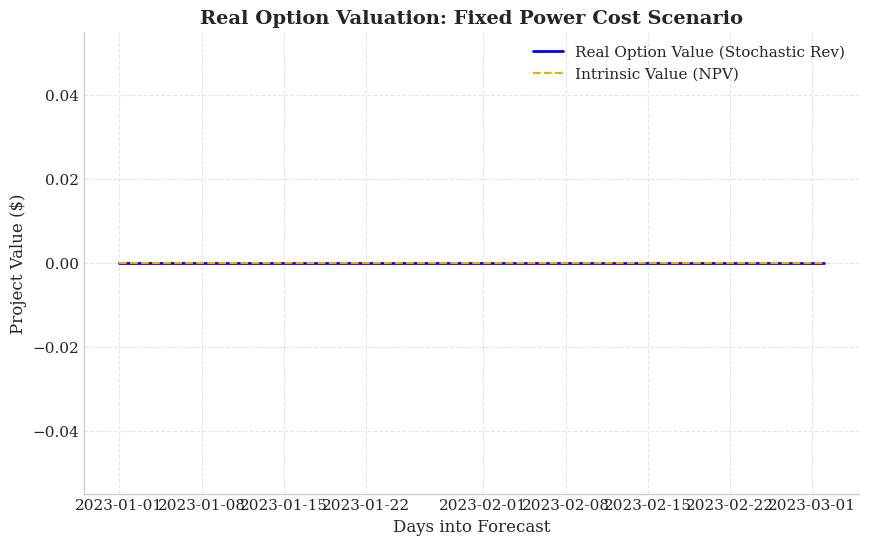

In [47]:
df_ro_fixed = results_fixed[0] # Option Value
df_int_fixed = results_fixed[2] # Intrinsic Value (NPV)

# 5. Visualize Results
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Mean Option Value vs Mean Intrinsic Value over time
ax.plot(df_ro_fixed.mean(axis=0), label="Real Option Value (Stochastic Rev)", color='blue', linewidth=2)
ax.plot(df_int_fixed.mean(axis=0), label="Intrinsic Value (NPV)", color='orange', linestyle='--')

ax.set_title("Real Option Valuation: Fixed Power Cost Scenario")
ax.set_ylabel("Project Value ($)")
ax.set_xlabel("Days into Forecast")
ax.legend()

export_figure(fig, "ro_value_fixed_cost")

# 6. Export Key Metrics
ro_val_t0 = df_ro_fixed.iloc[0, 0]
int_val_t0 = df_int_fixed.iloc[0, 0]
option_premium = ro_val_t0 - int_val_t0

fixed_cost_results = {
    "FixedPowerROValue": f"{ro_val_t0:,.0f}",
    "FixedPowerNPV": f"{int_val_t0:,.0f}",
    "FixedPowerPremium": f"{option_premium:,.0f}"
}
export_params(fixed_cost_results, "ro_results_fixed")

print(f"--- Results (Fixed Power) ---")
print(f"Real Option Value: ${ro_val_t0:,.0f}")
print(f"Intrinsic NPV:     ${int_val_t0:,.0f}")
print(f"Option Premium:    ${option_premium:,.0f} (Value of Flexibility)")

## 6. Final Discussion

Here the final discussion